In [2]:
%pip install torchmetrics
%pip install torchmetrics[detection]

Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 7.4 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
from torchvision.datasets import VOCDetection
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms as T
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchvision.ops import batched_nms
import torch.nn as nn
from tqdm import tqdm
from IPython.display import clear_output
from torch import optim
from torchvision.models.detection import retinanet_resnet50_fpn
from torchvision.models.detection.retinanet import RetinaNetClassificationHead

In [4]:
dataset = VOCDetection('/kaggle/working', download=True)

100%|██████████| 1999639040/1999639040 [01:29<00:00, 22310591.67it/s]


Extracting /kaggle/working/VOCtrainval_11-May-2012.tar to /kaggle/working


In [5]:
#!g1.1
target_names = []

for obj in dataset:
    target_names.extend([x['name'] for x in obj[1]['annotation']['object']])

target_names = list(set(target_names))

In [6]:
target2idx = {name: i for i, name in enumerate(target_names)}
idx2target = {i: name for i, name in enumerate(target_names)}

In [7]:
def target_transform(voc_target):
    target = {}
    
    target['boxes'] = torch.tensor([
        [
            float(x['bndbox']['xmin']),
            float(x['bndbox']['ymin']),
            float(x['bndbox']['xmax']),
            float(x['bndbox']['ymax'])
        ] for x in voc_target['annotation']['object']
    ], dtype = torch.float32)
    target['labels'] = torch.tensor([target2idx[x['name']] for x in voc_target['annotation']['object']],
                                    dtype=torch.int64)
    
    return target

In [8]:
def show(imgs):
    to_pil = T.ToPILImage()
    
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(16, 8))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = to_pil(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

def draw_boxes_single_image(image, boxes, labels):
    colors = ["red" for _ in boxes]

    show(draw_bounding_boxes(image, boxes, labels, colors=colors, width=5))

In [9]:
#!g1.1
def collate_fn(batch):
    return tuple(zip(*batch))

dataset_train = VOCDetection(
    '/kaggle/working',
    image_set='train',
    transform=T.ToTensor(),
    target_transform=target_transform
)

dataset_test = VOCDetection(
    '/kaggle/working',
    image_set='val',
    transform=T.ToTensor(),
    target_transform=target_transform
)

train_loader = DataLoader(dataset_train, batch_size=8, shuffle=True, num_workers=8, pin_memory=True, collate_fn=collate_fn)
valid_loader = DataLoader(dataset_test, batch_size=8, shuffle=False, num_workers=8, pin_memory=True, collate_fn=collate_fn)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
model = retinanet_resnet50_fpn(pretrained=True)
model.head.classification_head = RetinaNetClassificationHead(in_channels=256, num_anchors=9, num_classes=len(target_names))


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth
100%|██████████| 130M/130M [00:03<00:00, 44.0MB/s] 


In [11]:
def intersiction_over_union(bbox1, bbox2):
    int_x0 = max(bbox1[0], bbox2[0])
    int_y0 = max(bbox1[1], bbox1[1])
    
    int_x1 = min(bbox1[2], bbox2[2])
    int_y1 = min(bbox1[3], bbox1[3])
    
    intersiction = max(int_x1 - int_x0, 0) * max(int_y1 - int_y0, 0)
    area1 = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1])
    area2 = (bbox2[2] - bbox2[0]) * (bbox2[3] - bbox2[1])
    
    return intersiction/ (area1+area2 - intersiction)

In [12]:
def apply_nms(pred, iou_thres=0.3):
    keep = batched_nms(pred['boxes'], pred['scores'], pred['labels'], iou_thres)
    
    final_pred = pred
    
    final_pred['boxes'] = final_pred['boxes'][keep]
    final_pred['scores'] = final_pred['scores'][keep]
    final_pred['labels'] = final_pred['labels'][keep]
    
    return final_pred

In [13]:
@torch.inference_mode()
def visualize(model, batch):
    model.eval()
    
    to_pil = T.ToPILImage()
    to_tensor = T.PILToTensor()

    xs, ys = batch

    for i, (x, y) in enumerate(zip(xs, ys)):
        prediction = {k: v.to(device) for k, v in model([x.to(device)])[0].items()}

        prediction = apply_nms(prediction)

        x = to_tensor(to_pil(x.cpu()))

        true_boxes = draw_bounding_boxes(x, boxes=y['boxes'], labels=[idx2target[label.item()] for label in y['labels']], width=5, colors='red')
        predicted_boxes = draw_bounding_boxes(x, boxes=prediction['boxes'], labels=[idx2target[label.item()] for label in prediction['labels']], width=5, colors='red')
        
        fig, ax = plt.subplots(1, 2, figsize=(20, 10), facecolor='white')

        ax[0].imshow(to_pil(true_boxes))
        ax[1].imshow(to_pil(predicted_boxes))

        ax[0].axis('off')
        ax[1].axis('off')

        ax[0].set_title('Target boxes')
        ax[1].set_title('Predicted boxes')

        plt.subplots_adjust(wspace=0, hspace=0.1)
        plt.show()

        if i >= 5:
            break

In [14]:
#!g1.1
def train(model):
    model.train()

    for x, y in tqdm(train_loader, desc='Train'):
        x = list(_.to(device).float() for _ in x)
        y = [{k: v.to(device) for k, v in t.items()} for t in y]

        optimizer.zero_grad()

        output = model(x, y)
        
        loss_sum = sum(loss for loss in output.values())

        loss_sum.backward()

        optimizer.step()

In [15]:
#!g1.1
@torch.inference_mode()
def evaluate(model, loader):
    model.eval()
    
    metric = MeanAveragePrecision()

    for x, y in tqdm(loader, desc='Evaluation'):
        x = list(_.to(device).float() for _ in x)

        output = model(x)
        
        output = [{k: v.cpu() for k, v in t.items()} for t in output]

        metric.update(output, y)

    return metric.compute()['map']

In [16]:
#!g1.1

def plot_stats(
    train_map: list[float],
    valid_map: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' mAP')
    
    plt.plot(train_map, label='Train mAP')
    plt.plot(valid_map, label='Valid mAP')
    plt.legend()
    plt.grid()

    plt.show()

In [17]:
#!g1.1
def whole_train_valid_cycle(model, num_epochs, title):
    batch = next(iter(valid_loader))

    for epoch in range(num_epochs):
        train(model)

        clear_output()

        visualize(model, batch)

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [19]:
#!g1.1
model = model.to(device)

optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=1e-4)

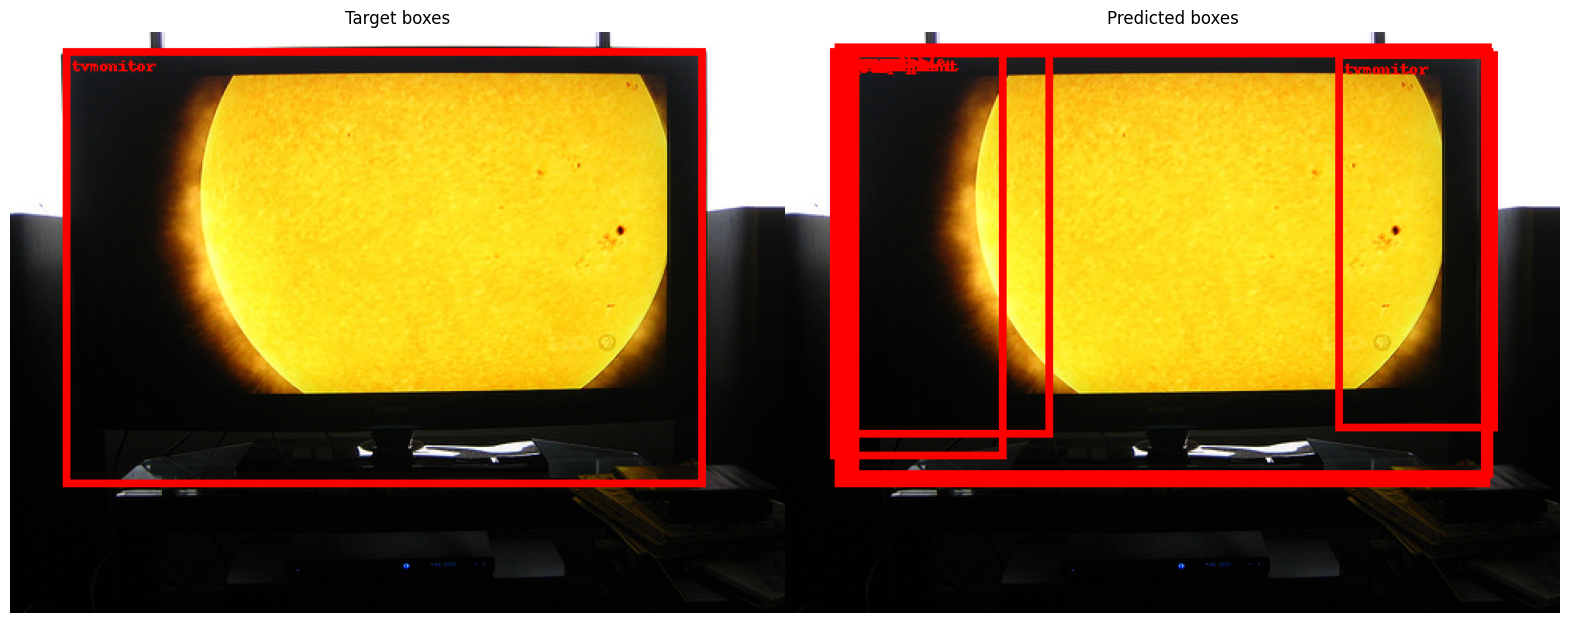

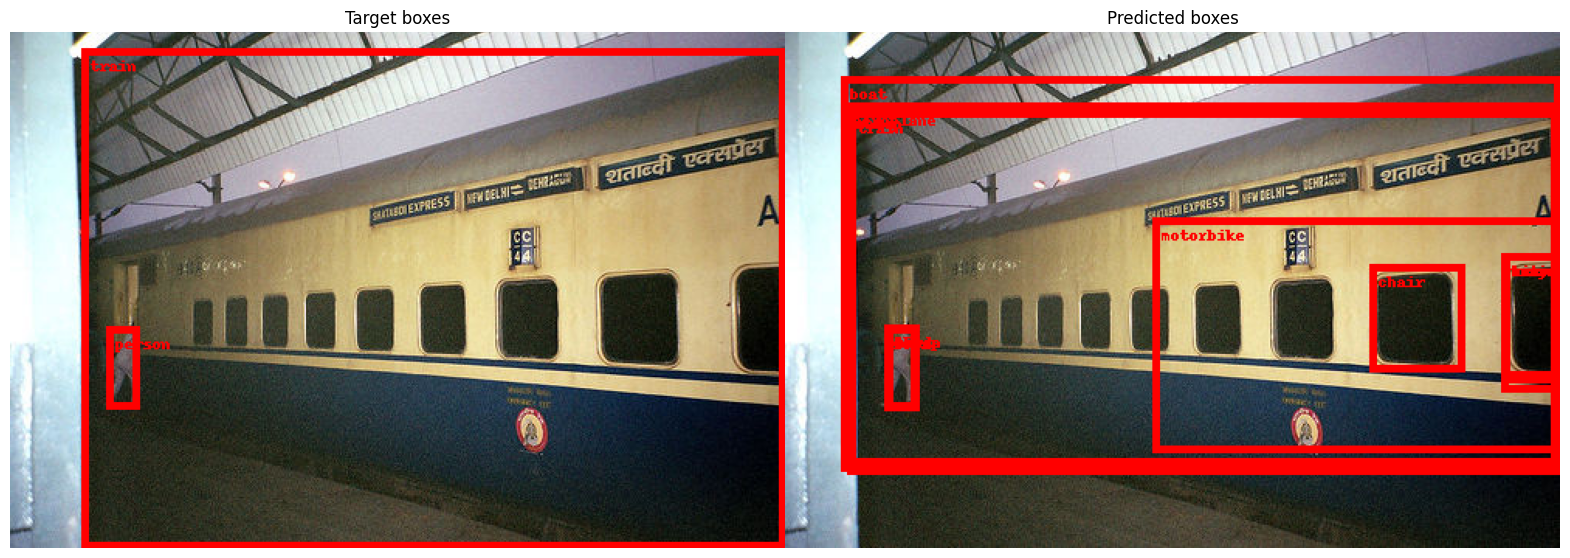

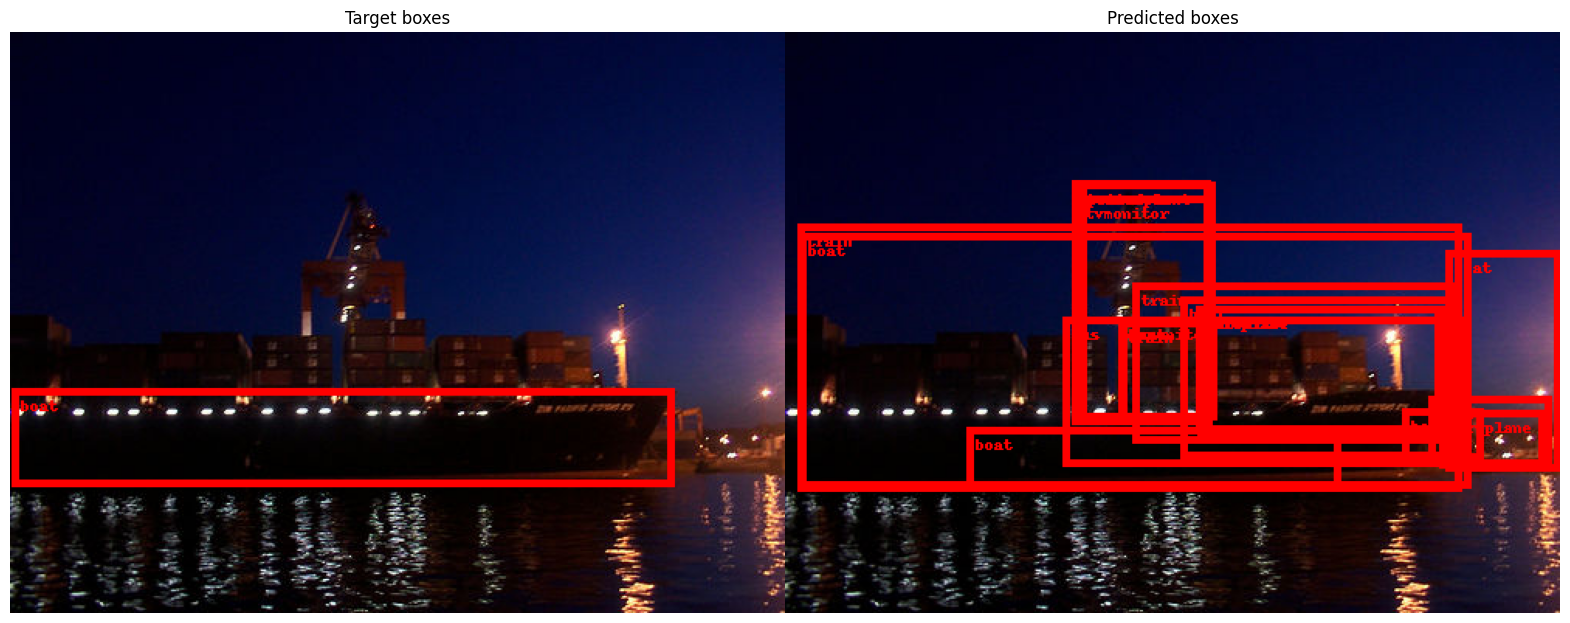

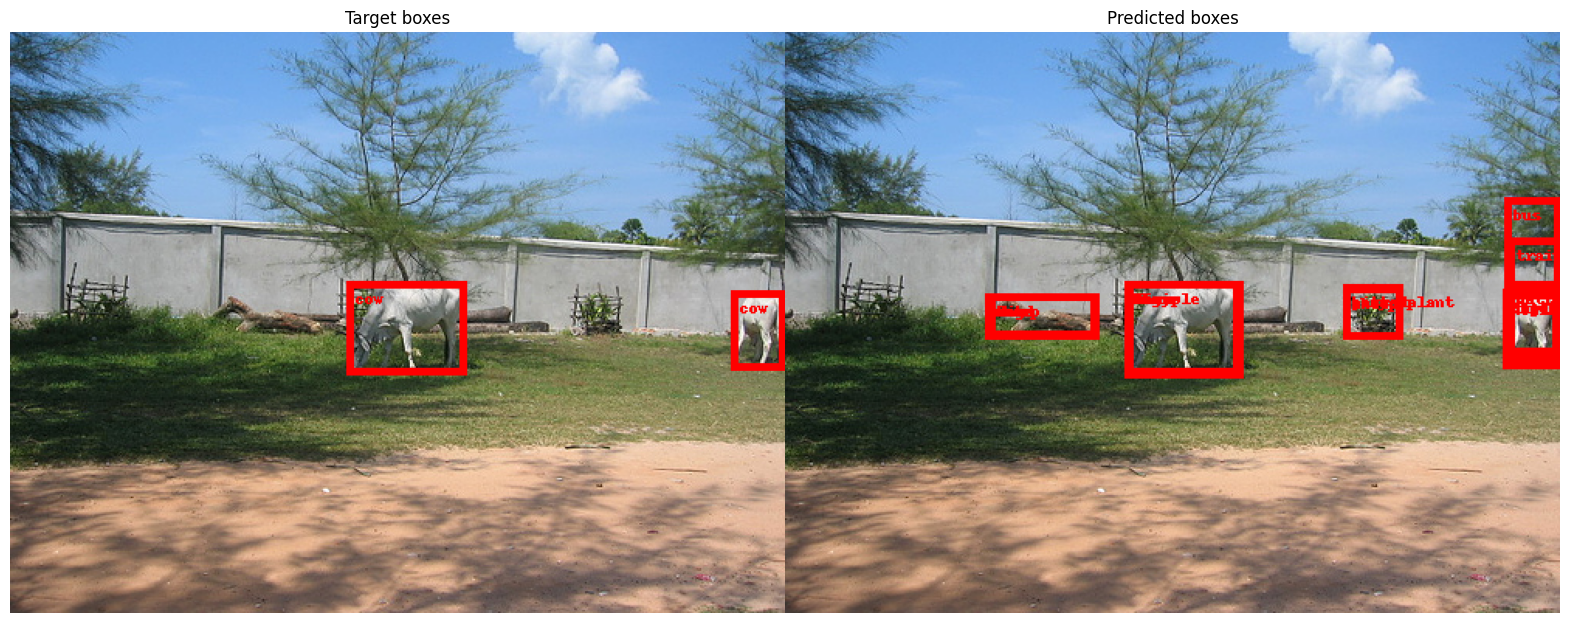

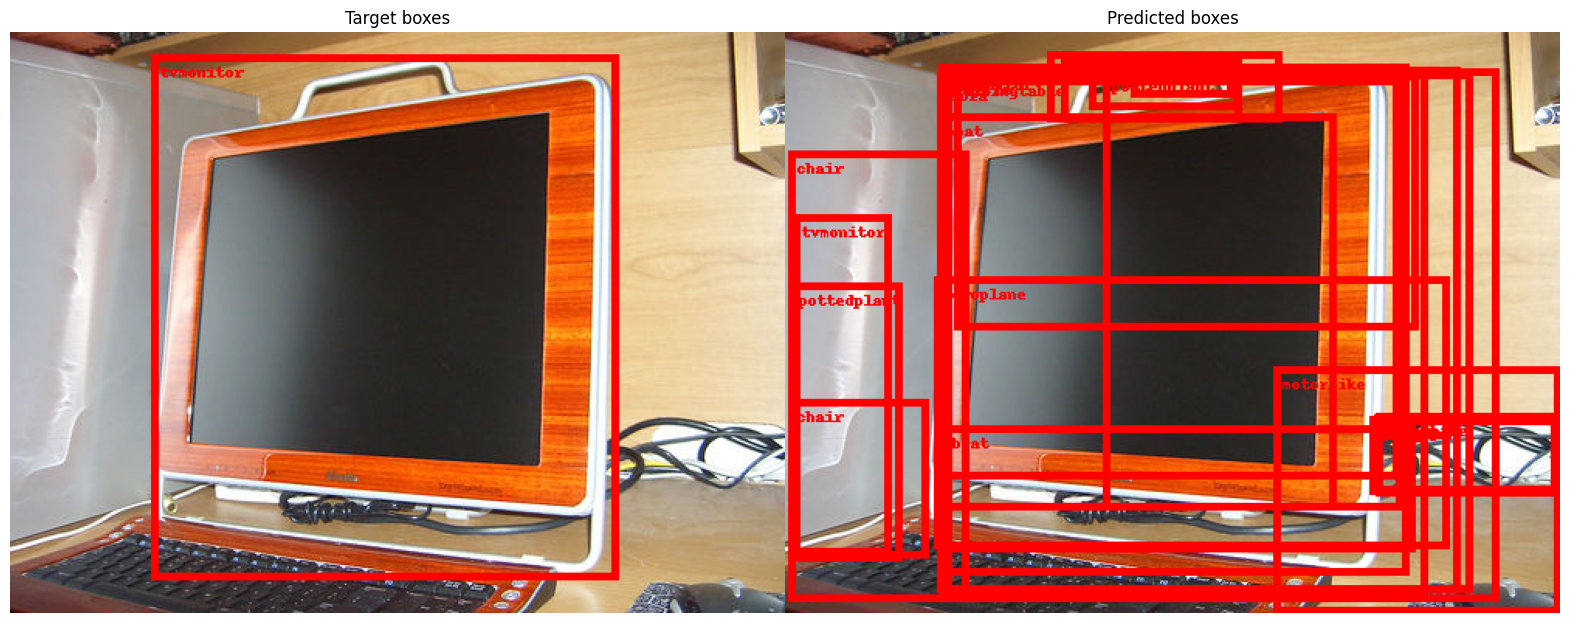

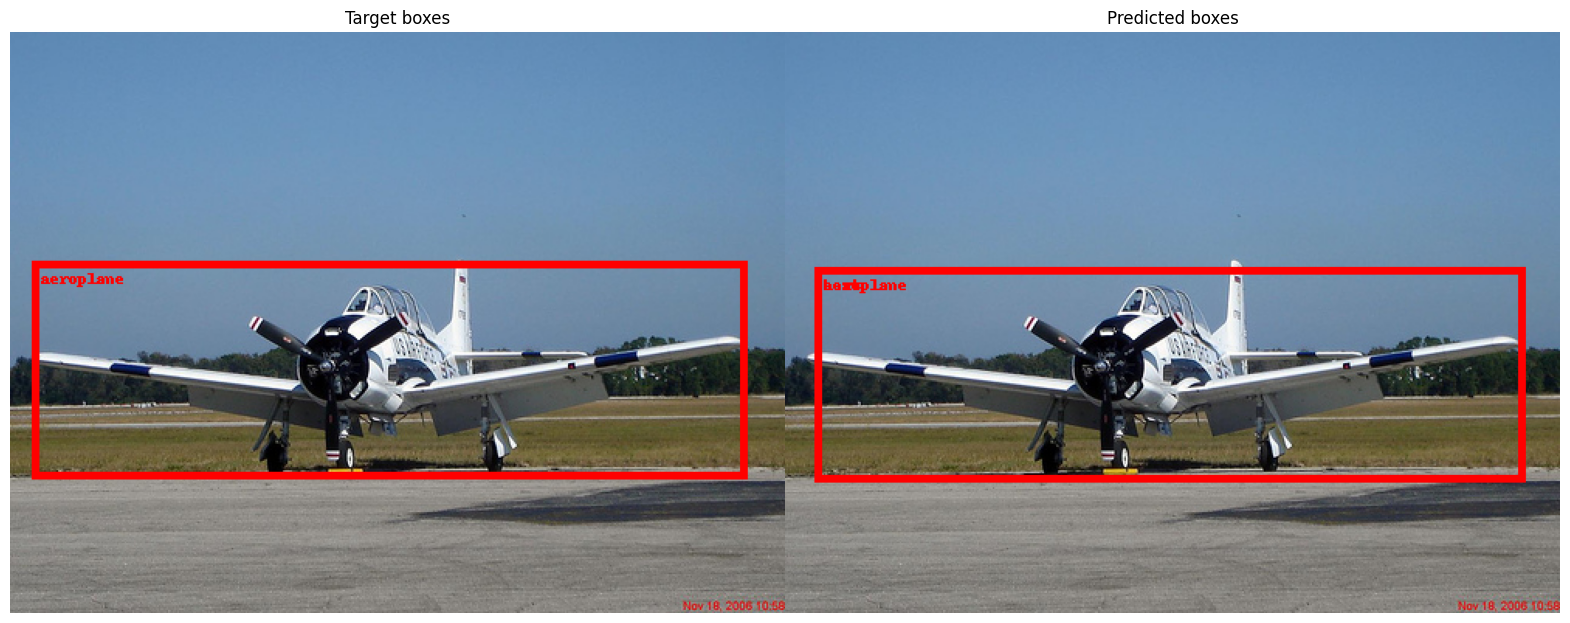

In [20]:
#!g1.1
whole_train_valid_cycle(model, 10, 'RetinaNET')

In [21]:
train_map = evaluate(model, train_loader)
valid_map = evaluate(model, valid_loader)

print(f'Train mAP {train_map:.5f} Valid mAP {valid_map:.5f}')

Evaluation:   0%|          | 0/715 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028
Evaluation: 100%|██████████| 728/728 [07:27<00:00,  1.63it/s]


Train mAP 0.69609 Valid mAP 0.39506
